In [1]:
import os
import numpy as np
import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

# Import PointNet++ utility functions
from torch.utils.data import DataLoader

def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist



def index_points(points, idx):
    """

    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N, dtype=torch.float32).to(device) * 1e10  # Ensure Float type
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1).float()  # Ensure dist is Float type
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, 3]
        new_xyz: query points, [B, S, 3]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx


def sample_and_group(npoint, radius, nsample, xyz, points, returnfps=False):
    """
    Input:
        npoint:
        radius:
        nsample:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, npoint, nsample, 3]
        new_points: sampled points data, [B, npoint, nsample, 3+D]
    """
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
    torch.cuda.empty_cache()
    new_xyz = index_points(xyz, fps_idx)
    torch.cuda.empty_cache()
    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    torch.cuda.empty_cache()
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    torch.cuda.empty_cache()
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)
    torch.cuda.empty_cache()

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm
    if returnfps:
        return new_xyz, new_points, grouped_xyz, fps_idx
    else:
        return new_xyz, new_points


def sample_and_group_all(xyz, points):
    """
    Input:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, 3]
        new_points: sampled points data, [B, 1, N, 3+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C).to(device)
    grouped_xyz = xyz.view(B, 1, N, C)
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points


class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points


class PointNetSetAbstractionMsg(nn.Module):
    def __init__(self, npoint, radius_list, nsample_list, in_channel, mlp_list):
        super(PointNetSetAbstractionMsg, self).__init__()
        self.npoint = npoint
        self.radius_list = radius_list
        self.nsample_list = nsample_list
        self.conv_blocks = nn.ModuleList()
        self.bn_blocks = nn.ModuleList()
        for i in range(len(mlp_list)):
            convs = nn.ModuleList()
            bns = nn.ModuleList()
            last_channel = in_channel + 3
            for out_channel in mlp_list[i]:
                convs.append(nn.Conv2d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm2d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        B, N, C = xyz.shape
        S = self.npoint

        new_xyz = index_points(xyz, farthest_point_sample(xyz, S))
        new_points_list = []
        for i, radius in enumerate(self.radius_list):
            K = self.nsample_list[i]
            group_idx = query_ball_point(radius, K, xyz, new_xyz)
            grouped_xyz = index_points(xyz, group_idx)
            grouped_xyz -= new_xyz.view(B, S, 1, C)
            if points is not None:
                grouped_points = index_points(points, group_idx)
                grouped_points = torch.cat([grouped_points, grouped_xyz], dim=-1)
            else:
                grouped_points = grouped_xyz

            grouped_points = grouped_points.permute(0, 3, 2, 1)  # [B, D, K, S]
            for j in range(len(self.conv_blocks[i])):
                conv = self.conv_blocks[i][j]
                bn = self.bn_blocks[i][j]
                grouped_points =  F.relu(bn(conv(grouped_points)))
            new_points = torch.max(grouped_points, 2)[0]  # [B, D', S]
            new_points_list.append(new_points)

        new_xyz = new_xyz.permute(0, 2, 1)
        new_points_concat = torch.cat(new_points_list, dim=1)
        return new_xyz, new_points_concat

        
# Define GhostModule
class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels, ratio=2, kernel_size=1, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        init_channels = max(1, int(out_channels / ratio))
        cheap_channels = out_channels - init_channels

        self.primary_conv = nn.Sequential(
            nn.Conv1d(in_channels, init_channels, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm1d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv1d(init_channels, cheap_channels, dw_size, stride=1, padding=dw_size // 2, groups=init_channels, bias=False),
            nn.BatchNorm1d(cheap_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)

        if x2.shape[1] < x1.shape[1]:  # Handle edge cases
            padding = x1.shape[1] - x2.shape[1]
            x2 = F.pad(x2, (0, 0, 0, padding))

        out = torch.cat([x1, x2], dim=1)
        return out[:, :x.shape[1], :]  # Ensure output shape matches


# Define GhostMLPModel
class GhostMLPModel(nn.Module):
    def __init__(self, num_class, normal_channel=False):
        super(GhostMLPModel, self).__init__()
        in_channel = 3 if normal_channel else 0

        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstractionMsg(512, [0.1, 0.2, 0.4], [16, 32, 128], in_channel, [[32, 32, 64], [64, 64, 128], [64, 96, 128]])
        self.sa2 = PointNetSetAbstractionMsg(128, [0.2, 0.4, 0.8], [32, 64, 128], 320, [[64, 64, 128], [128, 128, 256], [128, 128, 256]])
        self.sa3 = PointNetSetAbstraction(None, None, None, 640 + 3, [256, 512, 1024], True)

        self.encoder = nn.Sequential(
            GhostModule(1024, 512),
            nn.Dropout(0.4),
            GhostModule(512, 256),
            nn.Dropout(0.5),
            GhostModule(256, 256),  # Project features to 3 dimensions for compatibility with the mask
        )

        self.fc3 = nn.Linear(256, num_class)  # Classification layer

    def forward(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None

        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        # Flatten the global features
        x = l3_points.view(B, 1024)

        # Feature encoding
        features = self.encoder(x.unsqueeze(-1)).squeeze(-1)  # [B, 3] after projection

        # Final classification output
        logits = F.log_softmax(self.fc3(features), dim=-1)

        return logits, l3_points, features  # Output logits, global features, and reduced features




In [2]:
B, N, S, C = 1, 1024, 512, 3
radius = 0.2
nsample = 16

xyz = torch.rand(B, N, C).cuda()  # All points
new_xyz = torch.rand(B, S, C).cuda()  # Query points

group_idx = query_ball_point(radius, nsample, xyz, new_xyz)
print("group_idx shape:", group_idx.shape)  # Should be [B, S, nsample]


group_idx shape: torch.Size([1, 512, 16])


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataloader import SinglePoint
from tqdm import tqdm

# Normalize point cloud
def pc_normalize(pc):
    centroid = pc.mean(axis=0)
    pc -= centroid
    m = (pc**2).sum(axis=1).max()**0.5
    pc /= m
    return pc

# Custom collate function for DataLoader
def collate_fn(batch):
    points = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    points = [pc_normalize(point_set) for point_set in points]
    points = torch.tensor(points, dtype=torch.float32).permute(0, 2, 1)  # [B, 3, N]
    labels = torch.tensor(labels, dtype=torch.long)
    return points, labels

# Training loop
def train(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        with tqdm(dataloader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            for points, labels in tepoch:
                points, labels = points.to(device), labels.to(device)
                optimizer.zero_grad()

                # Forward pass
                logits, _, _ = model(points)

                # Compute loss
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = logits.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                tepoch.set_postfix(loss=loss.item(), accuracy=100.0 * correct / total)
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {100.0 * correct / total:.2f}%")


# Main script
if __name__ == "__main__":
    # Parameters
    num_classes = 40  # Based on the classnames in the dataloader
    num_epochs = 10
    batch_size = 32
    learning_rate = 0.001
    save_path = "ghostmlp_model.pth"
    dataset_root = "../data/modelnetdata/*/train"  # Update this to your dataset path

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize dataset and dataloader
    train_dataset = SinglePoint(dataset_root)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    # Initialize model, loss, optimizer
    model = GhostMLPModel(num_class=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train(model, train_loader, criterion, optimizer, num_epochs, device)

    # Save the model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Epoch 1/10:   0%|          | 0/5739 [00:00<?, ?batch/s]C:\Users\User\AppData\Local\Temp\ipykernel_1488\3943462930.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  points = torch.tensor(points, dtype=torch.float32).permute(0, 2, 1)  # [B, 3, N]
Epoch 1/10: 100%|██████████| 5739/5739 [22:02:36<00:00, 13.83s/batch, accuracy=74.5, loss=0.207]     


Epoch 1/10 - Loss: 4823.9940, Accuracy: 74.47%


Epoch 2/10:  25%|██▍       | 1424/5739 [3:39:40<11:16:02,  9.40s/batch, accuracy=82.9, loss=0.905]

In [ ]:
import numpy as np

def get_xyz_shape(file_path):
    # Load the .xyz file into a NumPy array
    data = np.loadtxt(file_path)

    # Return the shape of the data
    return data.shape

# Example usage
file_path = "../data/modelnetdata/airplane/train/airplane_0001_001.xyz"
shape = get_xyz_shape(file_path)
print(f"The shape of the .xyz file is: {shape}")
GhostMLPModel

The shape of the .xyz file is: (1024, 3)


__main__.GhostMLPModel

In [ ]:
import os
import argparse
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from dataloader import SinglePoint

parser = argparse.ArgumentParser()
parser.add_argument("-bs", "--batchSize", type=int, default=1)
parser.add_argument("-num_class", type=int, default=40)
parser.add_argument('--val_path', default='../data/modelnetdata/*/test', help='Path to the test data')
parser.add_argument('--train_path', default='../data/modelnetdata/*/train', help='Path to the train data')
parser.add_argument('--output_data_path', default='../data/modelnet_trained_feature/', help='Output feature directory')
parser.add_argument("--workers", type=int, default=4, help='Number of DataLoader workers')
parser.set_defaults(train=False)


def save_features(features, scene_name, file_name, output_dir, split_name):
    """Save features to a specified directory."""
    out_file = os.path.join(output_dir, scene_name, split_name)
    os.makedirs(out_file, exist_ok=True)
    file_path = os.path.join(out_file, file_name + '.pth')
    torch.save(features.cpu(), file_path)


    # Tracking metrics
def evaluate(loader, split_name):
    """Evaluate the model on a dataset (train or val)."""
    mean_correct = []
    class_acc = np.zeros((args.num_class, 3))
    output_dir = args.output_data_path

    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            points, target, scene_name, file_name = data[0], data[1], data[2], data[3]

            # Debugging: Check the shape of points
            print(f"Points shape before transpose: {points.shape}")

            # Ensure points is a tensor and has the expected shape
            if not isinstance(points, torch.Tensor):
                points = torch.tensor(points)

            # Preprocess points
            points = points.transpose(1, 2).float().cuda()  # Swap dimensions 1 and 2
            target = target.cuda()

            # Forward pass
            pred, _, features = model(points)

            # Save features with the explicit split_name
            file_name_no_ext = os.path.splitext(os.path.basename(file_name[-1]))[0]
            save_features(features, scene_name[-1], file_name_no_ext, output_dir, split_name)

            # Voting mechanism
            vote_pool = torch.zeros(target.shape[0], args.num_class).cuda()
            vote_pool += pred
            pred_choice = vote_pool.data.max(1)[1]

            # Accuracy calculation
            for cat in np.unique(target.cpu()):
                class_acc[cat, 0] += pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum().item()
                class_acc[cat, 1] += target[target == cat].shape[0]
            correct = pred_choice.eq(target.long().data).cpu().sum().item()
            mean_correct.append(correct / points.size(0))

        class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
        instance_acc = np.mean(mean_correct)
        mean_class_acc = np.mean(class_acc[:, 2])

        print(f"{split_name} Instance Accuracy: {instance_acc:.4f}, Class Accuracy: {mean_class_acc:.4f}")
        return instance_acc, mean_class_acc



if __name__ == '__main__':
    args, _  = parser.parse_known_args()

    # Load datasets and dataloaders
    train_dataset = SinglePoint(args.train_path)
    train_loader = DataLoader(train_dataset, shuffle=False, batch_size=args.batchSize, num_workers=args.workers)
    val_dataset = SinglePoint(args.val_path)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=args.batchSize, num_workers=args.workers)

    # Initialize the model
    model = GhostMLPModel(args.num_class).cuda()
    model.eval()

    # Evaluate on train and val sets
    print("Evaluating on Train Set...")
    evaluate(train_loader, "Train")
    print("Evaluating on Validation Set...")
    evaluate(val_loader, "Validation")


Evaluating on Train Set...


  0%|          | 0/183640 [00:00<?, ?it/s]

In [ ]:
import torch

# Replace 'file_path' with the path to your .pth file
file_path = "../data/modelnet_trained_feature/airplane/Train/airplane_0001_001.pth"

# Load and print the entire content of the .pth file
try:
    features = torch.load(file_path)
    
    # If it's a dictionary, print keys and their associated values
    if isinstance(features, dict):
        print("Content of the .pth file:")
        for key, value in features.items():
            print(f"{key}:")
            print(value)
    else:
        # Print directly if it's not a dictionary
        print("Content of the .pth file:")
        print(features)
        
except Exception as e:
    print(f"Error reading the .pth file: {e}")


Content of the .pth file:
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7138e-03, 0.0000e+00, 6.1926e-04,
         1.8625e-03, 1.9308e-04, 8.1920e-04, 1.2489e-03, 0.0000e+00, 9.2528e-04,
         1.7765e-03, 3.5468e-04, 0.0000e+00, 0.0000e+00, 8.5227e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3547e-04,
         0.0000e+00, 1.0643e-04, 6.6540e-04, 9.4780e-05, 4.3867e-04, 3.0095e-04,
         0.0000e+00, 3.9032e-04, 0.0000e+00, 4.9707e-05, 0.0000e+00, 0.0000e+00,
         1.3510e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00]])


C:\Users\User\AppData\Local\Temp\ipykernel_9228\2853942481.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(file_path)


Features shape: (1, 512)
Cannot reduce to 2 components. Using n_components=1 instead.


C:\Users\User\AppData\Local\Temp\ipykernel_18056\1352075715.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("../data/modelnet_trained_feature/airpl

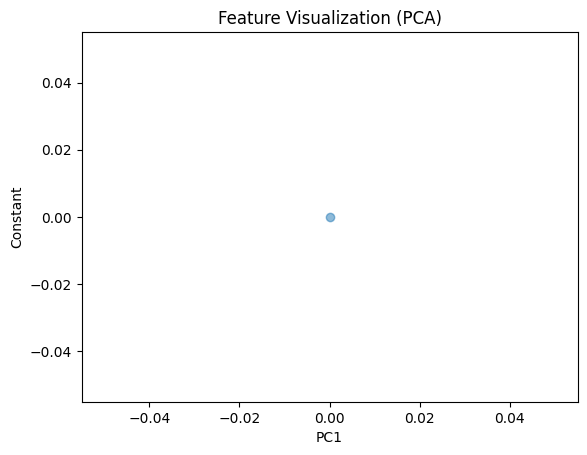

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Load the .pth file
features = torch.load("../data/modelnet_trained_feature/airplane/Train/airplane_0001_001.pth")

# Convert tensor to NumPy for visualization
# Convert tensor to NumPy for visualization
features_np = (
    features.cpu().numpy() if isinstance(features, torch.Tensor) 
    else features['features'].cpu().numpy()
)

# Check the shape of features
print(f"Features shape: {features_np.shape}")

# Ensure n_components does not exceed min(n_samples, n_features)
n_samples, n_features = features_np.shape[0], features_np.shape[1] if len(features_np.shape) > 1 else 1
n_components = min(2, n_samples, n_features)

if n_components < 2:
    print(f"Cannot reduce to 2 components. Using n_components={n_components} instead.")

# Reduce to 2D using PCA
pca = PCA(n_components=n_components)
features_2d = pca.fit_transform(features_np)

# Plot the reduced features
plt.scatter(features_2d[:, 0], features_2d[:, 1] if n_components == 2 else [0] * len(features_2d), alpha=0.5)
plt.title("Feature Visualization (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2" if n_components == 2 else "Constant")
plt.show()


Classification below with another version of GhostMLP with classification component added

In [ ]:
class GhostMLP(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(GhostMLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.classifier = nn.Linear(latent_dim, output_dim)  # Classification layer

    def forward(self, x):
        latent_features = self.encoder(x)  # Extracted features
        class_scores = self.classifier(latent_features)  # Class scores
        return latent_features, class_scores


In [ ]:
# Initialize the extended model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GhostMLP(input_dim=1024, latent_dim=64, output_dim=3).to(device)


In [ ]:
import argparse
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import MultiviewPoint  # Updated dataset class

def seed_torch(seed=9990):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def evaluate_model(model, val_loader, device, num_classes=40):
    model.eval()
    all_correct_points = 0
    all_points = 0
    wrong_class = np.zeros(num_classes)
    samples_class = np.zeros(num_classes)

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Ensure inputs are Float
            inputs = inputs.float()
            print(f"Input shape before reshaping: {inputs.shape}")  # Debug
            print(f"Labels shape: {labels.shape}")  # Debug

            # Flatten last two dimensions and reshape for the model
            batch_size, num_views, feature_dim1, feature_dim2 = inputs.shape
            inputs = inputs.view(batch_size, num_views, -1)  # Flatten last two dimensions
            inputs = inputs.view(batch_size, -1)  # Combine all views
            print(f"Input shape after reshaping: {inputs.shape}")  # Debug

            # Forward pass
            outputs = model(inputs)  # Outputs could be a tuple
            if isinstance(outputs, tuple):
                _, class_scores = outputs  # Unpack the tuple
            else:
                class_scores = outputs  # Single output tensor

            print(f"Outputs shape: {class_scores.shape}")  # Debug

            # Predictions
            preds = torch.argmax(class_scores, dim=-1)
            print(f"Preds shape: {preds.shape}")  # Debug

            # Calculate results
            results = preds == labels
            correct_points = torch.sum(results.long())
            all_correct_points += correct_points.item()
            all_points += results.size(0)

            for i in range(results.size(0)):
                label = labels[i].item()
                samples_class[label] += 1
                if not results[i].item():
                    wrong_class[label] += 1

    # Calculate accuracies
    class_acc = (samples_class - wrong_class) / samples_class
    val_mean_class_acc = np.mean(class_acc)
    val_overall_acc = all_correct_points / all_points

    print(f"Validation Mean Class Accuracy: {val_mean_class_acc:.4f}")
    print(f"Validation Overall Accuracy: {val_overall_acc:.4f}")
    print(f"Class Accuracy: {class_acc}")
    return val_overall_acc, val_mean_class_acc



# Manually set arguments in Jupyter Notebook
args = argparse.Namespace(
    name="log",
    batch_size=128,
    num_classes=3,
    ##model_checkpoint="../checkpoints/ghostmlp_model.pth",  # Adjust the checkpoint path
    val_path="../data/modelnet_features/*/test",
    workers=4,
)

# Seed for reproducibility
seed_torch()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load validation dataset
val_dataset = MultiviewPoint(args.val_path)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)
print(f"Number of validation samples: {len(val_dataset)}")

# Initialize model and load checkpoint
model = GhostMLP(input_dim=20 * 1024 * 64, latent_dim=64, output_dim=args.num_classes).to(device)
##model.load_state_dict(torch.load(args.model_checkpoint, map_location=device))
##print(f"Model loaded from {args.model_checkpoint}")

# Evaluate the model
val_overall_acc, val_mean_class_acc = evaluate_model(model, val_loader, device, num_classes=args.num_classes)


Number of validation samples: 286
Input shape before reshaping: torch.Size([128, 20, 1024, 64])
Labels shape: torch.Size([128])
Input shape after reshaping: torch.Size([128, 1310720])
Outputs shape: torch.Size([128, 3])
Preds shape: torch.Size([128])
Input shape before reshaping: torch.Size([128, 20, 1024, 64])
Labels shape: torch.Size([128])
Input shape after reshaping: torch.Size([128, 1310720])
Outputs shape: torch.Size([128, 3])
Preds shape: torch.Size([128])
Input shape before reshaping: torch.Size([30, 20, 1024, 64])
Labels shape: torch.Size([30])
Input shape after reshaping: torch.Size([30, 1310720])
Outputs shape: torch.Size([30, 3])
Preds shape: torch.Size([30])
Validation Mean Class Accuracy: 0.3333
Validation Overall Accuracy: 0.3007
Class Accuracy: [0. 0. 1.]


In [ ]:
import argparse
# Other imports
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import MultiviewPoint  # Your dataset class

# Rest of the script


def seed_torch(seed=9990):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def evaluate_model(model, val_loader, device, num_classes=40):
    model.eval()
    all_correct_points = 0
    all_points = 0
    wrong_class = np.zeros(num_classes)
    samples_class = np.zeros(num_classes)

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Ensure inputs are Float
            inputs = inputs.float()
            print(f"Input shape: {inputs.shape}")

            outputs = model(inputs)
            _, class_scores = outputs  # Unpack the tuple
            preds = torch.argmax(class_scores, dim=-1)


            results = preds == labels
            correct_points = torch.sum(results.long())
            all_correct_points += correct_points.item()
            all_points += results.size(0)
            print(f"Labels shape: {labels.shape}")

            for i in range(results.size(0)):
                label = labels[i].item()
                samples_class[label] += 1
                if not results[i].item():
                    wrong_class[label] += 1

    class_acc = (samples_class - wrong_class) / samples_class
    val_mean_class_acc = np.mean(class_acc)
    val_overall_acc = all_correct_points / all_points

    print(f"Validation Mean Class Accuracy: {val_mean_class_acc:.4f}")
    print(f"Validation Overall Accuracy: {val_overall_acc:.4f}")
    print(f"Class Accuracy: {class_acc}")
    return val_overall_acc, val_mean_class_acc


# Manually set arguments in Jupyter Notebook
args = argparse.Namespace(
    name="log",
    batch_size=128,
    num_classes=3,
    ##model_checkpoint="../checkpoints/ghostmlp_model.pth",  # Adjust the checkpoint path
    val_path="../data/modelnet_features/*/test",
    workers=4,
)

# Seed for reproducibility
seed_torch()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load validation dataset
val_dataset = MultiviewPoint(args.val_path)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)
print(f"Number of validation samples: {len(val_dataset)}")

# Initialize model and load checkpoint
model = GhostMLP(input_dim=128, latent_dim=64, output_dim=args.num_classes).to(device)
##model.load_state_dict(torch.load(args.model_checkpoint, map_location=device))
##print(f"Model loaded from {args.model_checkpoint}")

# Evaluate the model
val_overall_acc, val_mean_class_acc = evaluate_model(model, val_loader, device, num_classes=args.num_classes)


Number of validation samples: 286
Input shape: torch.Size([128])
Labels shape: torch.Size([128, 20, 1024, 64])


RuntimeError: a Tensor with 1310720 elements cannot be converted to Scalar